# Predict specimen disease status from age/sex/ethnicity data only

And export included specimen lists for other confounder testing.

(Can't do this prediction task for "healthy only" subset - because all y is the same value)


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from IPython.display import display, Markdown
import genetools

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import sklearn.base
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [3]:
from malid import config, helpers, logger
from malid.datamodels import healthy_label
from malid.external import model_evaluation

In [4]:
# rare ancestries already set to ethnicity_condensed=NaN
df = helpers.get_all_specimen_info()
df

,participant_label,specimen_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,...,cmv,disease_severity,specimen_time_point_days,cov2_seropositivity,survived_filters,is_peak,in_training_set,past_exposure,disease.separate_past_exposures,test_fold_id
0,BFI-0007450,M369-S001,Covid19,9 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,9.0,Not exposed,True,True,True,False,Covid19,0.0
1,BFI-0007450,M371-S003,Covid19,22 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,22.0,Not exposed,True,False,False,False,Covid19,NaN
2,BFI-0007450,M371-S014,Covid19,27 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,27.0,Not exposed,True,False,False,False,Covid19,NaN
3,BFI-0007453,M369-S004,Covid19,8 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-negative (ICU),64.0,...,NaN,ICU,8.0,Not exposed,True,False,False,False,Covid19,NaN
4,BFI-0007453,M369-S005,Covid19,11 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-negative (ICU),64.0,...,NaN,ICU,11.0,Not exposed,True,False,False,False,Covid19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,BFI-0010187,M460-S092,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,29.0,...,NaN,NaN,NaN,Not exposed,False,False,False,False,Hepatitis C,NaN
1148,BFI-0010188,M460-S048,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,63.0,...,NaN,NaN,NaN,Not exposed,False,False,False,False,Hepatitis C,NaN
1149,BFI-0010188,M460-S071,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,63.0,...,NaN,NaN,NaN,Not exposed,True,False,False,False,Hepatitis C,NaN
1150,BFI-0010188,M460-S076,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,63.0,...,NaN,NaN,NaN,Not exposed,True,False,False,False,Hepatitis C,NaN


In [5]:
df["age_group_binary"].value_counts()

under 50    583
50+         229
Name: age_group_binary, dtype: int64

In [6]:
df["age_group_binary"].isna().value_counts()

False    812
True     340
Name: age_group_binary, dtype: int64

In [ ]:
df["age_group_pediatric"].value_counts()

In [ ]:
df["age_group_pediatric"].isna().value_counts()

In [7]:
df

,participant_label,specimen_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,...,cmv,disease_severity,specimen_time_point_days,cov2_seropositivity,survived_filters,is_peak,in_training_set,past_exposure,disease.separate_past_exposures,test_fold_id
0,BFI-0007450,M369-S001,Covid19,9 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,9.0,Not exposed,True,True,True,False,Covid19,0.0
1,BFI-0007450,M371-S003,Covid19,22 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,22.0,Not exposed,True,False,False,False,Covid19,NaN
2,BFI-0007450,M371-S014,Covid19,27 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,27.0,Not exposed,True,False,False,False,Covid19,NaN
3,BFI-0007453,M369-S004,Covid19,8 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-negative (ICU),64.0,...,NaN,ICU,8.0,Not exposed,True,False,False,False,Covid19,NaN
4,BFI-0007453,M369-S005,Covid19,11 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-negative (ICU),64.0,...,NaN,ICU,11.0,Not exposed,True,False,False,False,Covid19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,BFI-0010187,M460-S092,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,29.0,...,NaN,NaN,NaN,Not exposed,False,False,False,False,Hepatitis C,NaN
1148,BFI-0010188,M460-S048,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,63.0,...,NaN,NaN,NaN,Not exposed,False,False,False,False,Hepatitis C,NaN
1149,BFI-0010188,M460-S071,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,63.0,...,NaN,NaN,NaN,Not exposed,True,False,False,False,Hepatitis C,NaN
1150,BFI-0010188,M460-S076,Hepatitis C,NaN,NaN,Boydlab,Hepatitis,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Hepatitis C,63.0,...,NaN,NaN,NaN,Not exposed,True,False,False,False,Hepatitis C,NaN


# Load actual specimens in different CV folds


* restrict df to only specimens that made it into folds
* then mark train_smaller and test fold memberships

In [8]:
# filter to selected training specimens
df = df[df["in_training_set"]].copy()
df

,participant_label,specimen_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,...,cmv,disease_severity,specimen_time_point_days,cov2_seropositivity,survived_filters,is_peak,in_training_set,past_exposure,disease.separate_past_exposures,test_fold_id
0,BFI-0007450,M369-S001,Covid19,9 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,9.0,Not exposed,True,True,True,False,Covid19,0.0
5,BFI-0007453,M371-S004,Covid19,15 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),64.0,...,NaN,ICU,15.0,Not exposed,True,True,True,False,Covid19,0.0
9,BFI-0007455,M371-S031,Covid19,12 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),36.0,...,NaN,ICU,12.0,Not exposed,True,True,True,False,Covid19,2.0
13,BFI-0007480,M371-S015,Covid19,14 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),40.0,...,NaN,ICU,14.0,Not exposed,True,True,True,False,Covid19,0.0
14,BFI-0007481,M371-S005,Covid19,32 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),66.0,...,NaN,ICU,32.0,Not exposed,True,True,True,False,Covid19,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,BFI-0010060,M456-S001,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,51.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,2.0
816,BFI-0010061,M456-S002,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,34.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,2.0
817,BFI-0010065,M456-S006,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,46.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,2.0
818,BFI-0010067,M456-S008,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,49.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,0.0


In [9]:
assert not df["test_fold_id"].isna().any()
df["test_fold_id"].value_counts()

1.0    163
0.0    161
2.0    156
Name: test_fold_id, dtype: int64

In [10]:
train_validation_memberships = helpers.get_all_specimen_cv_fold_info()
train_validation_memberships = train_validation_memberships[
    train_validation_memberships["fold_label"] != "test"
]
print(train_validation_memberships["fold_label"].value_counts())
train_validation_memberships

train_smaller    956
validation       484
Name: fold_label, dtype: int64


,participant_label,specimen_label,disease,disease_subtype,total_sequence_count,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,...,disease_severity,specimen_time_point_days,cov2_seropositivity,survived_filters,is_peak,in_training_set,past_exposure,disease.separate_past_exposures,fold_id,fold_label
0,BFI-0000234,M124-S014,Healthy/Background,Healthy/Background - HIV Negative,67707,NaN,Location: USA,Boydlab,HIV,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,0,validation
2,BFI-0000234,M124-S014,Healthy/Background,Healthy/Background - HIV Negative,67707,NaN,Location: USA,Boydlab,HIV,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,2,validation
3,BFI-0000234,M124-S014,Healthy/Background,Healthy/Background - HIV Negative,67707,NaN,Location: USA,Boydlab,HIV,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,-1,train_smaller
5,BFI-0000254,M111-S037,HIV,HIV Broad Neutralizing,74203,NaN,Location: Tanzania,Boydlab,HIV,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,HIV,1,train_smaller
6,BFI-0000254,M111-S037,HIV,HIV Broad Neutralizing,74203,NaN,Location: Tanzania,Boydlab,HIV,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,HIV,2,train_smaller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,BFI-0010244,M464-S045,Healthy/Background,Healthy/Background (children),62354,NaN,NaN,Boydlab,healthy_children,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,2,train_smaller
1915,BFI-0010244,M464-S045,Healthy/Background,Healthy/Background (children),62354,NaN,NaN,Boydlab,healthy_children,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,-1,validation
1916,BFI-0010245,M464-S046,Healthy/Background,Healthy/Background (children),48979,NaN,NaN,Boydlab,healthy_children,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,0,train_smaller
1917,BFI-0010245,M464-S046,Healthy/Background,Healthy/Background (children),48979,NaN,NaN,Boydlab,healthy_children,GeneLocus.BCR|TCR,...,NaN,NaN,Not exposed,True,True,True,False,Healthy/Background,1,train_smaller


In [11]:
for (fold_id, fold_label), grp in train_validation_memberships.groupby(
    ["fold_id", "fold_label"], observed=True
):
    colname = f"{fold_label}_fold_{fold_id}"
    df[colname] = False
    df.loc[
        df["specimen_label"].isin(grp["specimen_label"].tolist()),
        colname,
    ] = True

    print(colname)
    print(df[colname].value_counts())
    print()

train_smaller_fold_-1
True     319
False    161
Name: train_smaller_fold_-1, dtype: int64

validation_fold_-1
False    319
True     161
Name: validation_fold_-1, dtype: int64

train_smaller_fold_0
False    270
True     210
Name: train_smaller_fold_0, dtype: int64

validation_fold_0
False    371
True     109
Name: validation_fold_0, dtype: int64

train_smaller_fold_1
False    268
True     212
Name: train_smaller_fold_1, dtype: int64

validation_fold_1
False    375
True     105
Name: validation_fold_1, dtype: int64

train_smaller_fold_2
False    265
True     215
Name: train_smaller_fold_2, dtype: int64

validation_fold_2
False    371
True     109
Name: validation_fold_2, dtype: int64



In [12]:
df

,participant_label,specimen_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,...,disease.separate_past_exposures,test_fold_id,train_smaller_fold_-1,validation_fold_-1,train_smaller_fold_0,validation_fold_0,train_smaller_fold_1,validation_fold_1,train_smaller_fold_2,validation_fold_2
0,BFI-0007450,M369-S001,Covid19,9 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,Covid19,0.0,False,True,False,False,True,False,True,False
5,BFI-0007453,M371-S004,Covid19,15 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),64.0,...,Covid19,0.0,False,True,False,False,True,False,True,False
9,BFI-0007455,M371-S031,Covid19,12 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),36.0,...,Covid19,2.0,True,False,True,False,True,False,False,False
13,BFI-0007480,M371-S015,Covid19,14 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),40.0,...,Covid19,0.0,False,True,False,False,True,False,False,True
14,BFI-0007481,M371-S005,Covid19,32 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),66.0,...,Covid19,2.0,True,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,BFI-0010060,M456-S001,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,51.0,...,Lupus,2.0,True,False,True,False,True,False,False,False
816,BFI-0010061,M456-S002,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,34.0,...,Lupus,2.0,True,False,False,True,True,False,False,False
817,BFI-0010065,M456-S006,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,46.0,...,Lupus,2.0,True,False,True,False,True,False,False,False
818,BFI-0010067,M456-S008,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,49.0,...,Lupus,0.0,False,True,False,False,True,False,True,False


In [13]:
df.groupby(["disease", "study_name"]).size()

disease             study_name                 
Covid19             Covid19-Seattle                  5
                    Covid19-Stanford                48
                    Covid19-buffycoat               10
HIV                 HIV                             98
Healthy/Background  HIV                             43
                    Healthy-StanfordBloodCenter    102
                    Lupus                           27
                    New Lupus Paxgene                2
                    New Lupus RNA                    4
                    healthy_children                43
Lupus               Lupus                           34
                    Lupus Pediatric                 43
                    New Lupus Paxgene                5
                    New Lupus RNA                   16
dtype: int64

# EDA - specimen counts

In [14]:
# Here's who is missing age:
df[df["age_group"].isna()]["disease"].value_counts()

Covid19               3
Healthy/Background    2
Lupus                 2
Name: disease, dtype: int64

In [15]:
# Versus total counts
df["disease"].value_counts()

Healthy/Background    221
HIV                    98
Lupus                  98
Covid19                63
Name: disease, dtype: int64

In [16]:
# <20: only in HIV, Healthy, and Lupus
# 70-80: not in HIV
# 80+: only in Covid and Healthy

df.groupby(["age_group", "disease"]).size()

age_group  disease           
20-30      Covid19                7
           HIV                   44
           Healthy/Background    46
           Lupus                 14
30-40      Covid19               11
           HIV                   28
           Healthy/Background    26
           Lupus                 13
40-50      Covid19               14
           HIV                   20
           Healthy/Background    29
           Lupus                 10
50-60      Covid19                9
           HIV                    3
           Healthy/Background    40
           Lupus                 12
60-70      Covid19               11
           HIV                    1
           Healthy/Background    27
           Lupus                  2
70-80      Covid19                8
           Healthy/Background     4
           Lupus                  2
<20        HIV                    2
           Healthy/Background    47
           Lupus                 43
dtype: int64

In [17]:
# Age medians, ranges, and number of N/As by disease
# TODO: show boxplots too
for disease, disease_df in df.groupby("disease"):
    print(
        f"{disease}: median {disease_df['age'].median()} years old, range {disease_df['age'].min()} - {disease_df['age'].max()}, with {disease_df['age'].isna().sum()} NaNs"
    )

Covid19: median 48.0 years old, range 21.0 - 88.0, with 0 NaNs
HIV: median 31.0 years old, range 19.0 - 64.0, with 0 NaNs
Healthy/Background: median 35.0 years old, range 8.0 - 81.0, with 1 NaNs
Lupus: median 23.5 years old, range 7.0 - 71.0, with 2 NaNs


In [18]:
# Here's who is missing ethnicity:
df[df["ethnicity_condensed"].isna()]["disease"].value_counts()

Healthy/Background    29
Covid19               14
HIV                   11
Lupus                  3
Name: disease, dtype: int64

In [19]:
# Versus total counts
df["disease"].value_counts()

Healthy/Background    221
HIV                    98
Lupus                  98
Covid19                63
Name: disease, dtype: int64

In [20]:
# Take note:
df.groupby(["ethnicity_condensed", "disease"]).size()

ethnicity_condensed  disease           
African              Covid19                 2
                     HIV                    87
                     Healthy/Background     44
                     Lupus                  25
Asian                Covid19                 9
                     Healthy/Background     32
                     Lupus                  17
Caucasian            Covid19                10
                     Healthy/Background    110
                     Lupus                  40
Hispanic/Latino      Covid19                28
                     Healthy/Background      6
                     Lupus                  13
dtype: int64

In [21]:
# HIV is only African!
df.groupby(["disease", "ethnicity_condensed"]).size()

disease             ethnicity_condensed
Covid19             African                  2
                    Asian                    9
                    Caucasian               10
                    Hispanic/Latino         28
HIV                 African                 87
Healthy/Background  African                 44
                    Asian                   32
                    Caucasian              110
                    Hispanic/Latino          6
Lupus               African                 25
                    Asian                   17
                    Caucasian               40
                    Hispanic/Latino         13
dtype: int64

In [22]:
# Percentage of diseases (excluding N/As) by ancestry - these are percentages by specimens though
# TODO: show as stacked boxplots
for ethnicity, ethnicity_df in df.groupby("ethnicity_condensed"):
    print(f"{ethnicity}: {ethnicity_df.shape[0]} samples total")
    print(
        ethnicity_df["disease"]
        .value_counts(normalize=True)
        .apply(lambda fraction: f"{fraction*100:0.0f}%")
    )
    print()

African: 158 samples total
HIV                   55%
Healthy/Background    28%
Lupus                 16%
Covid19                1%
Name: disease, dtype: object

Asian: 58 samples total
Healthy/Background    55%
Lupus                 29%
Covid19               16%
Name: disease, dtype: object

Caucasian: 160 samples total
Healthy/Background    69%
Lupus                 25%
Covid19                6%
Name: disease, dtype: object

Hispanic/Latino: 47 samples total
Covid19               60%
Lupus                 28%
Healthy/Background    13%
Name: disease, dtype: object



In [23]:
# Here's who is missing sex:
df[df["sex"].isna()]["disease"].value_counts()

Lupus                 2
Healthy/Background    1
Name: disease, dtype: int64

In [24]:
# Lupus is very sex imbalanced, as expected
# Surprisignly HIV is sex imbalanced too?
df.groupby(["disease", "sex"]).size()

disease             sex
Covid19             F       33
                    M       30
HIV                 F       62
                    M       36
Healthy/Background  F      113
                    M      107
Lupus               F       83
                    M       13
dtype: int64

In [25]:
# Lupus is very sex imbalanced
df.groupby(["sex", "disease"]).size()

sex  disease           
F    Covid19                33
     HIV                    62
     Healthy/Background    113
     Lupus                  83
M    Covid19                30
     HIV                    36
     Healthy/Background    107
     Lupus                  13
dtype: int64

In [26]:
# Percentage of females (and number of N/As) by disease
# TODO: show as stacked boxplots
for disease, disease_df in df.groupby("disease"):
    n_total = disease_df["sex"].dropna().shape[0]
    if n_total == 0:
        print(f"{disease}: no sex information")
        continue

    n_female = disease_df["sex"].value_counts().loc["F"]
    n_nas = disease_df["sex"].isna().sum()
    assert (
        n_total + n_nas == disease_df.shape[0]
    ), "sanity check: should add up to total shape"
    print(
        f"{disease}: {n_female} female out of {n_total} total (not counting {n_nas} NaNs) = {n_female/n_total*100:0.0f}%."
    )

Covid19: 33 female out of 63 total (not counting 0 NaNs) = 52%.
HIV: 62 female out of 98 total (not counting 0 NaNs) = 63%.
Healthy/Background: 113 female out of 220 total (not counting 1 NaNs) = 51%.
Lupus: 83 female out of 96 total (not counting 2 NaNs) = 86%.


In [27]:
# CMV status for healthy individuals
df[df["disease"] == healthy_label]["disease_subtype"].value_counts()

Healthy/Background - CMV Negative    53
Healthy/Background - CMV Positive    48
Healthy/Background - HIV Negative    43
Healthy/Background (children)        43
Healthy/Background - SLE Negative    27
Unaffected Control                    6
Healthy/Background - CMV Unknown      1
Name: disease_subtype, dtype: int64

In [28]:
# Time points at the specimen level
for (disease, study_name), disease_df in df.groupby(["disease", "study_name"]):
    print(disease, study_name)
    print(disease_df["specimen_time_point"].value_counts())
    # print(disease_df["specimen_time_point_days"].describe()) # TODO
    print()

Covid19 Covid19-Seattle
16 days    2
8 days     1
37 days    1
22 days    1
Name: specimen_time_point, dtype: int64

Covid19 Covid19-Stanford
7 days     9
8 days     8
11 days    5
10 days    5
14 days    4
12 days    4
21 days    2
15 days    2
9 days     2
28 days    1
17 days    1
24 days    1
13 days    1
16 days    1
37 days    1
35 days    1
Name: specimen_time_point, dtype: int64

Covid19 Covid19-buffycoat
12 days    3
14 days    3
9 days     1
15 days    1
32 days    1
35 days    1
Name: specimen_time_point, dtype: int64

HIV HIV
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background HIV
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background Healthy-StanfordBloodCenter
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background Lupus
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background New Lupus Paxgene
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background New Lupus RNA
Series([], Name: specimen_

In [29]:
# Disease subtypes
for (disease, study_name), disease_df in df.groupby(["disease", "study_name"]):
    print(disease, study_name)
    print(disease_df["disease_subtype"].value_counts())
    print()

Covid19 Covid19-Seattle
Covid19 - Acute 2    5
Name: disease_subtype, dtype: int64

Covid19 Covid19-Stanford
Covid19 - Admit    33
Covid19 - ICU      15
Name: disease_subtype, dtype: int64

Covid19 Covid19-buffycoat
Covid19 - Sero-positive (ICU)      7
Covid19 - Sero-positive (Admit)    3
Name: disease_subtype, dtype: int64

HIV HIV
HIV Non Neutralizing      53
HIV Broad Neutralizing    45
Name: disease_subtype, dtype: int64

Healthy/Background HIV
Healthy/Background - HIV Negative    43
Name: disease_subtype, dtype: int64

Healthy/Background Healthy-StanfordBloodCenter
Healthy/Background - CMV Negative    53
Healthy/Background - CMV Positive    48
Healthy/Background - CMV Unknown      1
Name: disease_subtype, dtype: int64

Healthy/Background Lupus
Healthy/Background - SLE Negative    27
Name: disease_subtype, dtype: int64

Healthy/Background New Lupus Paxgene
Unaffected Control    2
Name: disease_subtype, dtype: int64

Healthy/Background New Lupus RNA
Unaffected Control    4
Name: dis

In [30]:
# Number of specimens per person
# If you see "1 n; 2 m", that means n people had 1 peak specimen each and m people had 2 peak specimens each.
for (disease, study_name), disease_df in df.groupby(["disease", "study_name"]):
    print(disease, study_name)
    print(disease_df["participant_label"].value_counts().value_counts())
    print()

Covid19 Covid19-Seattle
1    5
Name: participant_label, dtype: int64

Covid19 Covid19-Stanford
1    48
Name: participant_label, dtype: int64

Covid19 Covid19-buffycoat
1    10
Name: participant_label, dtype: int64

HIV HIV
1    92
2     3
Name: participant_label, dtype: int64

Healthy/Background HIV
1    43
Name: participant_label, dtype: int64

Healthy/Background Healthy-StanfordBloodCenter
1    102
Name: participant_label, dtype: int64

Healthy/Background Lupus
1    19
2     4
Name: participant_label, dtype: int64

Healthy/Background New Lupus Paxgene
1    2
Name: participant_label, dtype: int64

Healthy/Background New Lupus RNA
1    4
Name: participant_label, dtype: int64

Healthy/Background healthy_children
1    43
Name: participant_label, dtype: int64

Lupus Lupus
1    17
3     3
2     2
4     1
Name: participant_label, dtype: int64

Lupus Lupus Pediatric
1    43
Name: participant_label, dtype: int64

Lupus New Lupus Paxgene
1    5
Name: participant_label, dtype: int64

Lupus New 

# EDA - participant counts

List these instead of specimen counts

In [31]:
df_by_participant = df.groupby("participant_label").first()
df_by_participant.shape, df.shape

((461, 31), (480, 32))

In [32]:
df_by_participant

,specimen_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,sex,...,disease.separate_past_exposures,test_fold_id,train_smaller_fold_-1,validation_fold_-1,train_smaller_fold_0,validation_fold_0,train_smaller_fold_1,validation_fold_1,train_smaller_fold_2,validation_fold_2
participant_label,,,,,,,,,,,,,,,,,,,,,
BFI-0000234,M124-S014,Healthy/Background,None,Location: USA,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,27.0,M,...,Healthy/Background,1.0,True,False,False,True,False,False,False,True
BFI-0000254,M111-S037,HIV,None,Location: Tanzania,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",HIV Broad Neutralizing,48.0,F,...,HIV,0.0,False,True,False,False,True,False,True,False
BFI-0000255,M111-S033,HIV,None,Location: Tanzania,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",HIV Broad Neutralizing,33.0,F,...,HIV,2.0,True,False,True,False,True,False,False,False
BFI-0000256,M111-S038,HIV,None,Location: Tanzania,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",HIV Broad Neutralizing,31.0,F,...,HIV,2.0,True,False,False,True,True,False,False,False
BFI-0000258,M111-S055,HIV,None,Location: Tanzania,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",HIV Non Neutralizing,49.0,F,...,HIV,1.0,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BFI-0010240,M464-S041,Healthy/Background,None,None,Boydlab,healthy_children,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background (children),14.0,F,...,Healthy/Background,1.0,True,False,True,False,False,False,True,False
BFI-0010241,M464-S042,Healthy/Background,None,None,Boydlab,healthy_children,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background (children),15.0,M,...,Healthy/Background,1.0,True,False,True,False,False,False,True,False
BFI-0010243,M464-S044,Healthy/Background,None,None,Boydlab,healthy_children,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background (children),13.0,F,...,Healthy/Background,1.0,True,False,True,False,False,False,True,False


In [33]:
# number of participants by disease
df_by_participant["disease"].value_counts()

Healthy/Background    217
HIV                    95
Lupus                  86
Covid19                63
Name: disease, dtype: int64

In [34]:
# Age medians, ranges, and number of N/As by disease
# TODO: show as boxplots
for disease, disease_df in df_by_participant.groupby("disease"):
    print(
        f"{disease}: median {disease_df['age'].median()} years old, range {disease_df['age'].min()} - {disease_df['age'].max()}, with {disease_df['age'].isna().sum()} NaNs, total {disease_df.shape[0]} participants"
    )

Covid19: median 48.0 years old, range 21.0 - 88.0, with 0 NaNs, total 63 participants
HIV: median 31.0 years old, range 19.0 - 64.0, with 0 NaNs, total 95 participants
Healthy/Background: median 34.5 years old, range 8.0 - 81.0, with 1 NaNs, total 217 participants
Lupus: median 18.0 years old, range 7.0 - 71.0, with 2 NaNs, total 86 participants


In [35]:
# healthy controls - extreme ages
df_by_participant[
    (df_by_participant["age"] >= 80) & (df_by_participant["disease"] == healthy_label)
]["age"]

participant_label
BFI-0003063    81.0
Name: age, dtype: float64

In [36]:
# healthy controls - extreme ages
df_by_participant[
    (df_by_participant["age"] >= 75) & (df_by_participant["disease"] == healthy_label)
]["age"]

participant_label
BFI-0003063    81.0
BFI-0003120    78.0
Name: age, dtype: float64

In [37]:
# healthy controls - extreme ages
df_by_participant[
    (df_by_participant["age"] >= 70) & (df_by_participant["disease"] == healthy_label)
]["age"]

participant_label
BFI-0003063    81.0
BFI-0003116    74.0
BFI-0003120    78.0
BFI-0005462    70.0
BFI-0005463    70.0
Name: age, dtype: float64

In [38]:
# healthy controls - extreme ages
df_by_participant[
    (df_by_participant["age"] < 20) & (df_by_participant["disease"] == healthy_label)
]["age"]

participant_label
BFI-0003057    19.0
BFI-0003088    17.0
BFI-0003158    19.0
BFI-0003161    18.0
BFI-0010200    10.0
BFI-0010201    13.0
BFI-0010203    15.0
BFI-0010204    15.0
BFI-0010205    11.0
BFI-0010206     9.0
BFI-0010207    13.0
BFI-0010208    18.0
BFI-0010209    15.0
BFI-0010210    13.0
BFI-0010211    18.0
BFI-0010212    17.0
BFI-0010213    16.0
BFI-0010214    11.0
BFI-0010215    17.0
BFI-0010216    12.0
BFI-0010217    11.0
BFI-0010218     8.0
BFI-0010219    15.0
BFI-0010220    11.0
BFI-0010221    11.0
BFI-0010222    13.0
BFI-0010223    15.0
BFI-0010224     9.0
BFI-0010225    16.0
BFI-0010226    13.0
BFI-0010227    16.0
BFI-0010228    11.0
BFI-0010229    14.0
BFI-0010230    11.0
BFI-0010231    12.0
BFI-0010232    14.0
BFI-0010233    13.0
BFI-0010234     9.0
BFI-0010235    16.0
BFI-0010236     8.0
BFI-0010238    14.0
BFI-0010239    14.0
BFI-0010240    14.0
BFI-0010241    15.0
BFI-0010243    13.0
BFI-0010244    12.0
BFI-0010245    13.0
Name: age, dtype: float64

In [39]:
# Percentage of diseases (excluding N/As) by ancestry
# TODO: show as stacked boxplots
for ethnicity, ethnicity_df in df_by_participant.groupby("ethnicity_condensed"):
    print(f"{ethnicity}: {ethnicity_df.shape[0]} patients total")
    print(
        ethnicity_df["disease"]
        .value_counts(normalize=True)
        .apply(lambda fraction: f"{fraction*100:0.0f}%")
    )
    print()

African: 145 patients total
HIV                   59%
Healthy/Background    29%
Lupus                 11%
Covid19                1%
Name: disease, dtype: object

Asian: 58 patients total
Healthy/Background    55%
Lupus                 29%
Covid19               16%
Name: disease, dtype: object

Caucasian: 155 patients total
Healthy/Background    70%
Lupus                 24%
Covid19                6%
Name: disease, dtype: object

Hispanic/Latino: 47 patients total
Covid19               60%
Lupus                 28%
Healthy/Background    13%
Name: disease, dtype: object



In [40]:
# Percentage of ancestry (excluding N/As) by disease
# TODO: show as stacked boxplots
for disease, disease_df in df_by_participant.groupby("disease"):
    print(
        f"{disease}: {disease_df.shape[0]} patients total, including those without known ancestry info."
    )
    print(
        f"Among the {disease_df['ethnicity_condensed'].dropna().shape[0]} patients without N/As:"
    )
    print(
        disease_df["ethnicity_condensed"]
        .dropna()
        .value_counts(normalize=True)
        .apply(lambda fraction: f"{fraction*100:0.0f}%")
    )
    print()

Covid19: 63 patients total, including those without known ancestry info.
Among the 49 patients without N/As:
Hispanic/Latino    57%
Caucasian          20%
Asian              18%
African             4%
Name: ethnicity_condensed, dtype: object

HIV: 95 patients total, including those without known ancestry info.
Among the 85 patients without N/As:
African    100%
Name: ethnicity_condensed, dtype: object

Healthy/Background: 217 patients total, including those without known ancestry info.
Among the 188 patients without N/As:
Caucasian          57%
African            22%
Asian              17%
Hispanic/Latino     3%
Name: ethnicity_condensed, dtype: object

Lupus: 86 patients total, including those without known ancestry info.
Among the 83 patients without N/As:
Caucasian          45%
Asian              20%
African            19%
Hispanic/Latino    16%
Name: ethnicity_condensed, dtype: object



In [41]:
# Percentage of ancestry (including N/As) by disease
# TODO: show as stacked boxplots
for disease, disease_df in df_by_participant.groupby("disease"):
    print(
        f"{disease}: {disease_df.shape[0]} patients total, including {disease_df.shape[0] - disease_df['ethnicity_condensed'].dropna().shape[0]} without known ancestry info."
    )
    ethnicity_counts = (
        disease_df["ethnicity_condensed"].dropna().value_counts(normalize=False)
    )
    # add N/A counts
    ethnicity_counts.at["Unknown"] = disease_df["ethnicity_condensed"].isna().sum()
    # normalize to sum to 1
    ethnicity_counts = ethnicity_counts / ethnicity_counts.sum()
    print(ethnicity_counts.apply(lambda fraction: f"{fraction*100:0.0f}%"))
    print()

Covid19: 63 patients total, including 14 without known ancestry info.
Hispanic/Latino    44%
Caucasian          16%
Asian              14%
African             3%
Unknown            22%
Name: ethnicity_condensed, dtype: object

HIV: 95 patients total, including 10 without known ancestry info.
African    89%
Unknown    11%
Name: ethnicity_condensed, dtype: object

Healthy/Background: 217 patients total, including 29 without known ancestry info.
Caucasian          50%
African            19%
Asian              15%
Hispanic/Latino     3%
Unknown            13%
Name: ethnicity_condensed, dtype: object

Lupus: 86 patients total, including 3 without known ancestry info.
Caucasian          43%
Asian              20%
African            19%
Hispanic/Latino    15%
Unknown             3%
Name: ethnicity_condensed, dtype: object



In [42]:
# Raw counts of ancestry (including N/As) by disease
for disease, disease_df in df_by_participant.groupby("disease"):
    print(
        f"{disease}: {disease_df.shape[0]} patients total, including {disease_df.shape[0] - disease_df['ethnicity_condensed'].dropna().shape[0]} without known ancestry info."
    )
    ethnicity_counts = (
        disease_df["ethnicity_condensed"].dropna().value_counts(normalize=False)
    )
    # add N/A counts
    ethnicity_counts.at["Unknown"] = disease_df["ethnicity_condensed"].isna().sum()
    print(ethnicity_counts)
    print()

Covid19: 63 patients total, including 14 without known ancestry info.
Hispanic/Latino    28
Caucasian          10
Asian               9
African             2
Unknown            14
Name: ethnicity_condensed, dtype: int64

HIV: 95 patients total, including 10 without known ancestry info.
African    85
Unknown    10
Name: ethnicity_condensed, dtype: int64

Healthy/Background: 217 patients total, including 29 without known ancestry info.
Caucasian          108
African             42
Asian               32
Hispanic/Latino      6
Unknown             29
Name: ethnicity_condensed, dtype: int64

Lupus: 86 patients total, including 3 without known ancestry info.
Caucasian          37
Asian              17
African            16
Hispanic/Latino    13
Unknown             3
Name: ethnicity_condensed, dtype: int64



In [43]:
# Percentage of females (and number of N/As) by disease
# TODO: show as stacked boxplots
for disease, disease_df in df_by_participant.groupby("disease"):
    n_total = disease_df["sex"].dropna().shape[0]
    if n_total == 0:
        print(f"{disease}: no sex information")
        continue

    n_female = disease_df["sex"].value_counts().loc["F"]
    n_nas = disease_df["sex"].isna().sum()
    assert (
        n_total + n_nas == disease_df.shape[0]
    ), "sanity check: should add up to total shape"
    print(
        f"{disease}: {n_female} female out of {n_total} total (not counting {n_nas} NaNs) = {n_female/n_total*100:0.0f}%."
    )

Covid19: 33 female out of 63 total (not counting 0 NaNs) = 52%.
HIV: 61 female out of 95 total (not counting 0 NaNs) = 64%.
Healthy/Background: 109 female out of 216 total (not counting 1 NaNs) = 50%.
Lupus: 71 female out of 84 total (not counting 2 NaNs) = 85%.


## Participant counts within each batch (each `study_name`)

In [44]:
# Age medians, ranges, and number of N/As by study name (disease batch)
# TODO: show as boxplots
for (disease, study_name), disease_df in df_by_participant.groupby(
    ["disease", "study_name"]
):
    print(
        f"{disease}, {study_name}: median {disease_df['age'].median()} years old, range {disease_df['age'].min()} - {disease_df['age'].max()}, with {disease_df['age'].isna().sum()} NaNs, total {disease_df.shape[0]} participants"
    )

Covid19, Covid19-Seattle: median 57.0 years old, range 26.0 - 73.0, with 0 NaNs, total 5 participants
Covid19, Covid19-Stanford: median 44.5 years old, range 21.0 - 86.0, with 0 NaNs, total 48 participants
Covid19, Covid19-buffycoat: median 65.0 years old, range 36.0 - 88.0, with 0 NaNs, total 10 participants
HIV, HIV: median 31.0 years old, range 19.0 - 64.0, with 0 NaNs, total 95 participants
Healthy/Background, HIV: median 27.0 years old, range 20.0 - 51.0, with 0 NaNs, total 43 participants
Healthy/Background, Healthy-StanfordBloodCenter: median 51.5 years old, range 17.0 - 81.0, with 0 NaNs, total 102 participants
Healthy/Background, Lupus: median 42.5 years old, range 24.0 - 70.0, with 1 NaNs, total 23 participants
Healthy/Background, New Lupus Paxgene: median 47.5 years old, range 47.0 - 48.0, with 0 NaNs, total 2 participants
Healthy/Background, New Lupus RNA: median 49.0 years old, range 33.0 - 67.0, with 0 NaNs, total 4 participants
Healthy/Background, healthy_children: media

In [45]:
# Percentage of batches (excluding N/As) by ancestry
# TODO: show as stacked boxplots
for ethnicity, ethnicity_df in df_by_participant.groupby("ethnicity_condensed"):
    print(f"{ethnicity}: {ethnicity_df.shape[0]} patients total")
    print(
        ethnicity_df["study_name"]
        .value_counts(normalize=True)
        .apply(lambda fraction: f"{fraction*100:0.0f}%")
    )
    print()

African: 145 patients total
HIV                            78%
Lupus                          14%
New Lupus Paxgene               3%
Lupus Pediatric                 2%
Healthy-StanfordBloodCenter     1%
Covid19-Seattle                 1%
Covid19-Stanford                1%
New Lupus RNA                   1%
Name: study_name, dtype: object

Asian: 58 patients total
Healthy-StanfordBloodCenter    41%
Lupus Pediatric                26%
Covid19-Stanford               14%
healthy_children               14%
Covid19-Seattle                 2%
New Lupus RNA                   2%
New Lupus Paxgene               2%
Name: study_name, dtype: object

Caucasian: 155 patients total
Healthy-StanfordBloodCenter    46%
Lupus                          14%
healthy_children               14%
New Lupus RNA                  10%
Lupus Pediatric                 8%
Covid19-Stanford                5%
Covid19-Seattle                 1%
New Lupus Paxgene               1%
Name: study_name, dtype: object

Hispanic/Lati

In [46]:
def pretty_print_value_counts(ser):
    return ", ".join(
        [f"{value} {label}" for label, value in zip(ser.index, ser.values)]
    )

In [47]:
# Percentage of ancestry (including N/As) by disease and study name
# TODO: show as stacked boxplots
for (disease, study_name), disease_df in df_by_participant.groupby(
    ["disease", "study_name"]
):
    print(f"{disease}, {study_name}:")
    print(
        f"{disease_df.shape[0]} patients total, including {disease_df.shape[0] - disease_df['ethnicity_condensed'].dropna().shape[0]} without known ancestry info."
    )
    ethnicity_counts = (
        disease_df["ethnicity_condensed"].dropna().value_counts(normalize=False)
    )
    # add N/A counts
    ethnicity_counts.at["unknown"] = disease_df["ethnicity_condensed"].isna().sum()
    # normalize to sum to 1
    ethnicity_counts = ethnicity_counts / ethnicity_counts.sum()
    print(ethnicity_counts.apply(lambda fraction: f"{fraction*100:0.0f}%"))
    print(
        pretty_print_value_counts(
            ethnicity_counts.apply(lambda fraction: f"{fraction*100:0.0f}%")
        )
    )
    print()

Covid19, Covid19-Seattle:
5 patients total, including 1 without known ancestry info.
Caucasian    40%
Asian        20%
African      20%
unknown      20%
Name: ethnicity_condensed, dtype: object
40% Caucasian, 20% Asian, 20% African, 20% unknown

Covid19, Covid19-Stanford:
48 patients total, including 3 without known ancestry info.
Hispanic/Latino    58%
Caucasian          17%
Asian              17%
African             2%
unknown             6%
Name: ethnicity_condensed, dtype: object
58% Hispanic/Latino, 17% Caucasian, 17% Asian, 2% African, 6% unknown

Covid19, Covid19-buffycoat:
10 patients total, including 10 without known ancestry info.
unknown    100%
Name: ethnicity_condensed, dtype: object
100% unknown

HIV, HIV:
95 patients total, including 10 without known ancestry info.
African    89%
unknown    11%
Name: ethnicity_condensed, dtype: object
89% African, 11% unknown

Healthy/Background, HIV:
43 patients total, including 15 without known ancestry info.
African    65%
unknown    

In [48]:
# Percentage of females (and number of N/As) by disease
# TODO: show as stacked boxplots
for (disease, study_name), disease_df in df_by_participant.groupby(
    ["disease", "study_name"]
):
    n_total = disease_df["sex"].dropna().shape[0]
    if n_total == 0:
        print(f"{disease}, {study_name}: no sex information")
        continue

    n_female = (
        disease_df["sex"].value_counts().reindex(["M", "F"], fill_value=0).loc["F"]
    )
    n_nas = disease_df["sex"].isna().sum()
    assert (
        n_total + n_nas == disease_df.shape[0]
    ), "sanity check: should add up to total shape"
    print(
        f"{disease}, {study_name}: {n_female} female out of {n_total} total (not counting {n_nas} NaNs) = {n_female/n_total*100:0.0f}%."
    )

Covid19, Covid19-Seattle: 2 female out of 5 total (not counting 0 NaNs) = 40%.
Covid19, Covid19-Stanford: 25 female out of 48 total (not counting 0 NaNs) = 52%.
Covid19, Covid19-buffycoat: 6 female out of 10 total (not counting 0 NaNs) = 60%.
HIV, HIV: 61 female out of 95 total (not counting 0 NaNs) = 64%.
Healthy/Background, HIV: 22 female out of 43 total (not counting 0 NaNs) = 51%.
Healthy/Background, Healthy-StanfordBloodCenter: 44 female out of 102 total (not counting 0 NaNs) = 43%.
Healthy/Background, Lupus: 19 female out of 22 total (not counting 1 NaNs) = 86%.
Healthy/Background, New Lupus Paxgene: 0 female out of 2 total (not counting 0 NaNs) = 0%.
Healthy/Background, New Lupus RNA: 3 female out of 4 total (not counting 0 NaNs) = 75%.
Healthy/Background, healthy_children: 21 female out of 43 total (not counting 0 NaNs) = 49%.
Lupus, Lupus: 20 female out of 21 total (not counting 2 NaNs) = 95%.
Lupus, Lupus Pediatric: 32 female out of 43 total (not counting 0 NaNs) = 74%.
Lupus

In [49]:
# Time points. Ignore this - makes more sense to do at the specimen level.
for (disease, study_name), disease_df in df_by_participant.groupby(
    ["disease", "study_name"]
):
    print(disease, study_name)
    print(disease_df["specimen_time_point"].value_counts())
    # print(disease_df["specimen_time_point_days"].describe()) # TODO
    print()

Covid19 Covid19-Seattle
16 days    2
8 days     1
37 days    1
22 days    1
Name: specimen_time_point, dtype: int64

Covid19 Covid19-Stanford
7 days     9
8 days     8
11 days    5
10 days    5
14 days    4
12 days    4
21 days    2
15 days    2
9 days     2
28 days    1
17 days    1
24 days    1
13 days    1
16 days    1
37 days    1
35 days    1
Name: specimen_time_point, dtype: int64

Covid19 Covid19-buffycoat
12 days    3
14 days    3
9 days     1
15 days    1
32 days    1
35 days    1
Name: specimen_time_point, dtype: int64

HIV HIV
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background HIV
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background Healthy-StanfordBloodCenter
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background Lupus
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background New Lupus Paxgene
Series([], Name: specimen_time_point, dtype: int64)

Healthy/Background New Lupus RNA
Series([], Name: specimen_

In [50]:
# Disease subtypes
# (Look at specimen level instead?)
for (disease, study_name), disease_df in df_by_participant.groupby(
    ["disease", "study_name"]
):
    print(disease, study_name)
    print(disease_df["disease_subtype"].value_counts(normalize=False))
    print(
        disease_df["disease_subtype"]
        .value_counts(normalize=True)
        .apply(lambda fraction: f"{fraction*100:0.0f}%")
    )
    print()

Covid19 Covid19-Seattle
Covid19 - Acute 2    5
Name: disease_subtype, dtype: int64
Covid19 - Acute 2    100%
Name: disease_subtype, dtype: object

Covid19 Covid19-Stanford
Covid19 - Admit    33
Covid19 - ICU      15
Name: disease_subtype, dtype: int64
Covid19 - Admit    69%
Covid19 - ICU      31%
Name: disease_subtype, dtype: object

Covid19 Covid19-buffycoat
Covid19 - Sero-positive (ICU)      7
Covid19 - Sero-positive (Admit)    3
Name: disease_subtype, dtype: int64
Covid19 - Sero-positive (ICU)      70%
Covid19 - Sero-positive (Admit)    30%
Name: disease_subtype, dtype: object

HIV HIV
HIV Non Neutralizing      50
HIV Broad Neutralizing    45
Name: disease_subtype, dtype: int64
HIV Non Neutralizing      53%
HIV Broad Neutralizing    47%
Name: disease_subtype, dtype: object

Healthy/Background HIV
Healthy/Background - HIV Negative    43
Name: disease_subtype, dtype: int64
Healthy/Background - HIV Negative    100%
Name: disease_subtype, dtype: object

Healthy/Background Healthy-Stanfo

# Subselect for each task

In [51]:
assert not df["specimen_label"].duplicated().any()
df = df.set_index("specimen_label")
df

,participant_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,sex,...,disease.separate_past_exposures,test_fold_id,train_smaller_fold_-1,validation_fold_-1,train_smaller_fold_0,validation_fold_0,train_smaller_fold_1,validation_fold_1,train_smaller_fold_2,validation_fold_2
specimen_label,,,,,,,,,,,,,,,,,,,,,
M369-S001,BFI-0007450,Covid19,9 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,F,...,Covid19,0.0,False,True,False,False,True,False,True,False
M371-S004,BFI-0007453,Covid19,15 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),64.0,M,...,Covid19,0.0,False,True,False,False,True,False,True,False
M371-S031,BFI-0007455,Covid19,12 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),36.0,M,...,Covid19,2.0,True,False,True,False,True,False,False,False
M371-S015,BFI-0007480,Covid19,14 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),40.0,F,...,Covid19,0.0,False,True,False,False,True,False,False,True
M371-S005,BFI-0007481,Covid19,32 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),66.0,M,...,Covid19,2.0,True,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M456-S001,BFI-0010060,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,51.0,F,...,Lupus,2.0,True,False,True,False,True,False,False,False
M456-S002,BFI-0010061,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,34.0,F,...,Lupus,2.0,True,False,False,True,True,False,False,False
M456-S006,BFI-0010065,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,46.0,F,...,Lupus,2.0,True,False,True,False,True,False,False,False


In [52]:
df["age_group"].value_counts()

20-30    111
<20       92
30-40     78
40-50     73
50-60     64
60-70     41
70-80     14
Name: age_group, dtype: int64

In [53]:
df["age"].describe()

count    477.000000
mean      36.457023
std       17.904765
min        7.000000
25%       22.000000
50%       34.000000
75%       50.000000
max       88.000000
Name: age, dtype: float64

In [54]:
df[df["age"] >= 70]["age"].sort_values()

specimen_label
M281redo-S064    70.0
M281redo-S063    70.0
M281redo-S018    71.0
M418-S033        71.0
M404-S014        71.0
M281redo-S017    71.0
M418-S025        71.0
M369-S001        73.0
M404-S008        73.0
M418-S229        74.0
M64-067          74.0
M371-S024        77.0
M64-071          78.0
M418-S032        79.0
M64-014          81.0
M418-S031        83.0
M418-S184        86.0
M371-S023        88.0
Name: age, dtype: float64

In [55]:
df[df["age"] >= 80]["age"]

specimen_label
M371-S023    88.0
M418-S184    86.0
M418-S031    83.0
M64-014      81.0
Name: age, dtype: float64

In [56]:
df[df["age"] >= 70]["disease"].value_counts()

Covid19               11
Healthy/Background     5
Lupus                  2
Name: disease, dtype: int64

In [57]:
df[df["age"] >= 80]["disease"].value_counts()

Covid19               3
Healthy/Background    1
Name: disease, dtype: int64

In [58]:
df[df["disease"] == healthy_label]["age_group"].value_counts()

<20      47
20-30    46
50-60    40
40-50    29
60-70    27
30-40    26
70-80     4
Name: age_group, dtype: int64

In [59]:
print(df.shape)

# In "age_group" column, we have removed extreme ages with small sample size.
df_age = df.dropna(subset=["age_group"]).copy()
print(df_age.shape)

(480, 31)
(473, 31)


In [60]:
df_age["age_group"].value_counts()

20-30    111
<20       92
30-40     78
40-50     73
50-60     64
60-70     41
70-80     14
Name: age_group, dtype: int64

In [61]:
assert not df_age["age_group_binary"].isna().any()
df_age["age_group_binary"].value_counts()

under 50    354
50+         119
Name: age_group_binary, dtype: int64

In [ ]:
assert not df_age["age_group_pediatric"].isna().any()
df_age["age_group_pediatric"].value_counts()

In [62]:
df_age["disease"].value_counts()

Healthy/Background    219
HIV                    98
Lupus                  96
Covid19                60
Name: disease, dtype: int64

In [63]:
df_age_healthy_only = df_age[df_age["disease"] == healthy_label]
df_age_healthy_only = df_age_healthy_only.dropna(subset=["age_group"])
df.shape, df_age.shape, df_age_healthy_only.shape

((480, 31), (473, 31), (219, 31))

In [64]:
df_age_healthy_only["disease"].value_counts()

Healthy/Background    219
Name: disease, dtype: int64

In [65]:
df_age_healthy_only["disease_subtype"].value_counts()

Healthy/Background - CMV Negative    53
Healthy/Background - CMV Positive    47
Healthy/Background - HIV Negative    43
Healthy/Background (children)        43
Healthy/Background - SLE Negative    26
Unaffected Control                    6
Healthy/Background - CMV Unknown      1
Name: disease_subtype, dtype: int64

In [66]:
df_age_healthy_only["age_group"].value_counts()

<20      47
20-30    46
50-60    40
40-50    29
60-70    27
30-40    26
70-80     4
Name: age_group, dtype: int64

In [67]:
assert not df_age_healthy_only["age_group_binary"].isna().any()
df_age_healthy_only["age_group_binary"].value_counts()

under 50    148
50+          71
Name: age_group_binary, dtype: int64

In [ ]:
assert not df_age_healthy_only["age_group_pediatric"].isna().any()
df_age_healthy_only["age_group_pediatric"].value_counts()

<AxesSubplot:>

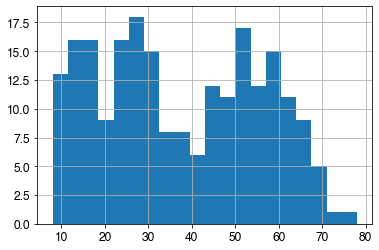

In [69]:
df_age_healthy_only["age"].hist(bins=20)

In [68]:
df_sex = df.copy()
df_sex = df_sex.dropna(subset=["sex"])
df.shape, df_sex.shape

((480, 31), (477, 31))

In [69]:
df_sex["disease"].value_counts()

Healthy/Background    220
HIV                    98
Lupus                  96
Covid19                63
Name: disease, dtype: int64

In [70]:
df_sex["sex"].value_counts()

F    291
M    186
Name: sex, dtype: int64

In [71]:
df_sex_healthy_only = df_sex[df_sex["disease"] == healthy_label]
df_sex_healthy_only = df_sex_healthy_only.dropna(subset=["sex"])
df.shape, df_sex.shape, df_sex_healthy_only.shape

((480, 31), (477, 31), (220, 31))

In [72]:
df_sex_healthy_only["disease"].value_counts()

Healthy/Background    220
Name: disease, dtype: int64

In [73]:
df_sex_healthy_only["disease_subtype"].value_counts()

Healthy/Background - CMV Negative    53
Healthy/Background - CMV Positive    48
Healthy/Background - HIV Negative    43
Healthy/Background (children)        43
Healthy/Background - SLE Negative    26
Unaffected Control                    6
Healthy/Background - CMV Unknown      1
Name: disease_subtype, dtype: int64

In [74]:
df_sex_healthy_only["sex"].value_counts()

F    113
M    107
Name: sex, dtype: int64

In [75]:
df_ethnicity = df.copy()
df_ethnicity = df_ethnicity.dropna(subset=["ethnicity_condensed"])
df.shape, df_ethnicity.shape

((480, 31), (423, 31))

In [76]:
df_ethnicity["disease"].value_counts()

Healthy/Background    192
Lupus                  95
HIV                    87
Covid19                49
Name: disease, dtype: int64

In [77]:
df_ethnicity["ethnicity_condensed"].value_counts()

Caucasian          160
African            158
Asian               58
Hispanic/Latino     47
Name: ethnicity_condensed, dtype: int64

In [78]:
df_ethnicity_healthy_only = df_ethnicity[df_ethnicity["disease"] == healthy_label]
df_ethnicity_healthy_only = df_ethnicity_healthy_only.dropna(
    subset=["ethnicity_condensed"]
)
df.shape, df_ethnicity.shape, df_ethnicity_healthy_only.shape

((480, 31), (423, 31), (192, 31))

In [79]:
df_ethnicity_healthy_only["disease"].value_counts()

Healthy/Background    192
Name: disease, dtype: int64

In [80]:
df_ethnicity_healthy_only["disease_subtype"].value_counts()

Healthy/Background - CMV Negative    53
Healthy/Background - CMV Positive    48
Healthy/Background (children)        31
Healthy/Background - HIV Negative    28
Healthy/Background - SLE Negative    26
Unaffected Control                    6
Name: disease_subtype, dtype: int64

In [81]:
df_ethnicity_healthy_only["ethnicity_condensed"].value_counts()

Caucasian          110
African             44
Asian               32
Hispanic/Latino      6
Name: ethnicity_condensed, dtype: int64

In [82]:
# Get subset with age + sex + ethnicity defined
df_all = df.loc[
    df_age.index.intersection(df_sex.index).intersection(df_ethnicity.index)
].copy()
df.shape, df_all.shape

((480, 31), (420, 31))

In [83]:
df_all["disease"].value_counts()

Healthy/Background    191
Lupus                  95
HIV                    87
Covid19                47
Name: disease, dtype: int64

In [84]:
df_all

,participant_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,sex,...,disease.separate_past_exposures,test_fold_id,train_smaller_fold_-1,validation_fold_-1,train_smaller_fold_0,validation_fold_0,train_smaller_fold_1,validation_fold_1,train_smaller_fold_2,validation_fold_2
specimen_label,,,,,,,,,,,,,,,,,,,,,
M404-S005,BFI-0007781,Covid19,8 days,COVID-19 sample from Seattle (Jim Heath),Boydlab,Covid19-Seattle,(((GeneLocus.BCR))),Covid19 - Acute 2,57.0,M,...,Covid19,2.0,True,False,True,False,True,False,False,False
M404-S008,BFI-0007782,Covid19,37 days,COVID-19 sample from Seattle (Jim Heath),Boydlab,Covid19-Seattle,(((GeneLocus.BCR))),Covid19 - Acute 2,73.0,F,...,Covid19,1.0,True,False,True,False,False,False,False,True
M404-S011,BFI-0007783,Covid19,16 days,COVID-19 sample from Seattle (Jim Heath),Boydlab,Covid19-Seattle,(((GeneLocus.BCR))),Covid19 - Acute 2,57.0,M,...,Covid19,2.0,True,False,False,True,True,False,False,False
M404-S014,BFI-0007784,Covid19,22 days,COVID-19 sample from Seattle (Jim Heath),Boydlab,Covid19-Seattle,(((GeneLocus.BCR))),Covid19 - Acute 2,71.0,F,...,Covid19,0.0,False,True,False,False,False,True,True,False
M418-S198,BFI-0009005,Covid19,11 days,COVID-19 sample from Sam Yang,Boydlab,Covid19-Stanford,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - ICU,68.0,M,...,Covid19,1.0,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M456-S001,BFI-0010060,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,51.0,F,...,Lupus,2.0,True,False,True,False,True,False,False,False
M456-S002,BFI-0010061,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,34.0,F,...,Lupus,2.0,True,False,False,True,True,False,False,False
M456-S006,BFI-0010065,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,46.0,F,...,Lupus,2.0,True,False,True,False,True,False,False,False


In [85]:
df_all["participant_label"].nunique()

402

In [86]:
df_all.groupby("disease")["participant_label"].nunique()

disease
Covid19                47
HIV                    85
Healthy/Background    187
Lupus                  83
Name: participant_label, dtype: int64

In [87]:
df_all.reset_index()["specimen_label"].nunique()

420

In [88]:
df_all.reset_index().groupby("disease")["specimen_label"].nunique()

disease
Covid19                47
HIV                    87
Healthy/Background    191
Lupus                  95
Name: specimen_label, dtype: int64

In [89]:
df_all_healthy_only = df.loc[
    df_age_healthy_only.index.intersection(df_sex_healthy_only.index).intersection(
        df_ethnicity_healthy_only.index
    )
].copy()
df.shape, df_all.shape, df_all_healthy_only.shape

((480, 31), (420, 31), (191, 31))

In [90]:
df_all_healthy_only["disease"].value_counts()

Healthy/Background    191
Name: disease, dtype: int64

In [91]:
df_all_healthy_only

,participant_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,sex,...,disease.separate_past_exposures,test_fold_id,train_smaller_fold_-1,validation_fold_-1,train_smaller_fold_0,validation_fold_0,train_smaller_fold_1,validation_fold_1,train_smaller_fold_2,validation_fold_2
specimen_label,,,,,,,,,,,,,,,,,,,,,
M124-S037,BFI-0002861,Healthy/Background,NaN,Location: Malawi,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,34.0,F,...,Healthy/Background,0.0,False,True,False,False,True,False,True,False
M124-S036,BFI-0002862,Healthy/Background,NaN,Location: Malawi,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,29.0,F,...,Healthy/Background,0.0,False,True,False,False,True,False,True,False
M124-S035,BFI-0002863,Healthy/Background,NaN,Location: Malawi,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,42.0,F,...,Healthy/Background,0.0,False,True,False,False,True,False,False,True
M124-S038,BFI-0002866,Healthy/Background,NaN,Location: South Africa,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,36.0,F,...,Healthy/Background,1.0,True,False,True,False,False,False,True,False
M124-S039,BFI-0002867,Healthy/Background,NaN,Location: South Africa,Boydlab,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,35.0,F,...,Healthy/Background,2.0,True,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M464-S033,BFI-0010232,Healthy/Background,NaN,NaN,Boydlab,healthy_children,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background (children),14.0,M,...,Healthy/Background,2.0,True,False,False,True,False,True,False,False
M464-S036,BFI-0010235,Healthy/Background,NaN,NaN,Boydlab,healthy_children,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background (children),16.0,M,...,Healthy/Background,1.0,True,False,True,False,False,False,False,True
M464-S037,BFI-0010236,Healthy/Background,NaN,NaN,Boydlab,healthy_children,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background (children),8.0,M,...,Healthy/Background,0.0,False,True,False,False,True,False,True,False


In [92]:
df_all_healthy_only["disease_subtype"].value_counts()

Healthy/Background - CMV Negative    53
Healthy/Background - CMV Positive    47
Healthy/Background (children)        31
Healthy/Background - HIV Negative    28
Healthy/Background - SLE Negative    26
Unaffected Control                    6
Name: disease_subtype, dtype: int64

In [93]:
# create a "defined CMV status" subset of "healthy controls with known age/sex/ethnicity" dataset
df_cmv_status = df_all_healthy_only.copy()
print(df_cmv_status["cmv"].isna().sum())

91


In [94]:
df_cmv_status = df_cmv_status.dropna(subset=["cmv"])
df_cmv_status["cmv"].value_counts()

CMV-    53
CMV+    47
Name: cmv, dtype: int64

In [95]:
for name, partdf in zip(
    [
        #         "age_group",
        #         "sex",
        #         "ethnicity_condensed",
        "all",
        #         "age_group_healthy_only",
        #         "sex_healthy_only",
        #         "ethnicity_condensed_healthy_only",
        #         "all_healthy_only",
        "cmv",
    ],
    [
        #         df_age,
        #         df_sex,
        #         df_ethnicity,
        df_all,
        #         df_age_healthy_only,
        #         df_sex_healthy_only,
        #         df_ethnicity_healthy_only,
        #         df_all_healthy_only,
        df_cmv_status,
    ],
):
    fname_out = (
        config.paths.dataset_specific_metadata
        / f"computed_metadata_for_confounder_model.{name}.tsv"
    )
    print(name, fname_out)
    partdf.to_csv(
        fname_out,
        sep="\t",
    )

all /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/metadata/computed_metadata_for_confounder_model.all.tsv
cmv /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/metadata/computed_metadata_for_confounder_model.cmv.tsv


In [96]:
# After filters, how many remaining participants
df_all["participant_label"].nunique(), df_all_healthy_only[
    "participant_label"
].nunique()

(402, 187)

In [97]:
# After filters, how many remaining specimens
df_all.reset_index()["specimen_label"].nunique(), df_all_healthy_only.reset_index()[
    "specimen_label"
].nunique()

(420, 191)